## Traffic sign classification

> By Raccoons AI team

In [1]:
import warnings
warnings.filterwarnings('ignore') 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

torchvision.disable_beta_transforms_warning()

In [2]:
import torch
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

input_size = 280

In [4]:
import torch
from PIL import Image 

class Resize:
    def __init__(self, size):
        self.size = size

    def __call__(self, image):
        w, h = image.size
        if max(h, w) == self.size:
            return image

        scale = self.size * 1.0 / max(w, h)
        new_w = int(w * scale + 0.5)
        new_h = int(h * scale + 0.5)
        return image.resize((new_w, new_h), Image.Resampling.BILINEAR)


class Pad:
    def __init__(self, size):
        self.size = size

    def __call__(self, image):
        h, w = image.shape[-2:]
        assert self.size >= h and self.size >= w
        pad = (0, self.size - w, 0, self.size - h)
        image = torch.nn.functional.pad(image, pad, value=0)
        return image

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ColorJitter(0.6, 0.4, 0.4),
        transforms.RandomApply([
            transforms.RandomRotation(degrees=(-20, 20))  
        ], p=0.3),
        Resize(size=input_size), 
        transforms.ToTensor(),
        Pad(input_size),
        normalize
    ]),
    'valid': transforms.Compose([
        transforms.ColorJitter(0.6, 0.4, 0.4),
        transforms.RandomApply([
            transforms.RandomRotation(degrees=(-20, 20))  
        ], p=0.3),
        Resize(size=input_size), 
        transforms.ToTensor(),
        Pad(input_size),
        normalize
    ])
}

data_dir = 'traffic_small/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=36, shuffle=True, num_workers=4) 
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda', index=0)

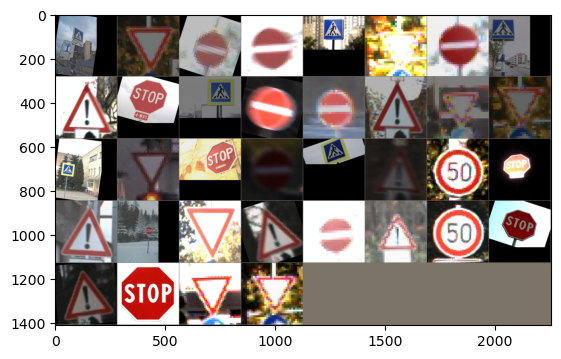

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out) #, title=[class_names[x] for x in classes]

In [8]:
class_names

['50', 'attention', 'give_way', 'no_entry', 'padestrian', 'stop']

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
model_ft = models.mobilenet_v2(pretrained=True)
model_ft.classifier[1] = torch.nn.Linear(model_ft.classifier[1].in_features, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1706 Acc: 0.9741
valid Loss: 0.6614 Acc: 0.8171

Epoch 1/24
----------
train Loss: 0.1859 Acc: 0.9684
valid Loss: 0.6282 Acc: 0.8415

Epoch 2/24
----------
train Loss: 0.1665 Acc: 0.9684
valid Loss: 0.6498 Acc: 0.8049

Epoch 3/24
----------
train Loss: 0.1738 Acc: 0.9741
valid Loss: 0.6630 Acc: 0.7927

Epoch 4/24
----------
train Loss: 0.1596 Acc: 0.9770
valid Loss: 0.6393 Acc: 0.8293

Epoch 5/24
----------
train Loss: 0.1678 Acc: 0.9770
valid Loss: 0.6453 Acc: 0.8415

Epoch 6/24
----------
train Loss: 0.1650 Acc: 0.9770
valid Loss: 0.6778 Acc: 0.7683

Epoch 7/24
----------
train Loss: 0.1674 Acc: 0.9741
valid Loss: 0.6282 Acc: 0.8049

Epoch 8/24
----------
train Loss: 0.1545 Acc: 0.9713
valid Loss: 0.6837 Acc: 0.8049

Epoch 9/24
----------
train Loss: 0.1703 Acc: 0.9741
valid Loss: 0.7116 Acc: 0.7805

Epoch 10/24
----------
train Loss: 0.1820 Acc: 0.9713
valid Loss: 0.6496 Acc: 0.8293

Epoch 11/24
----------
train Loss: 0.1616 Acc: 0.9741
valid Loss

In [13]:
torch.save(model_ft, 'traffic_sign_model.pth')